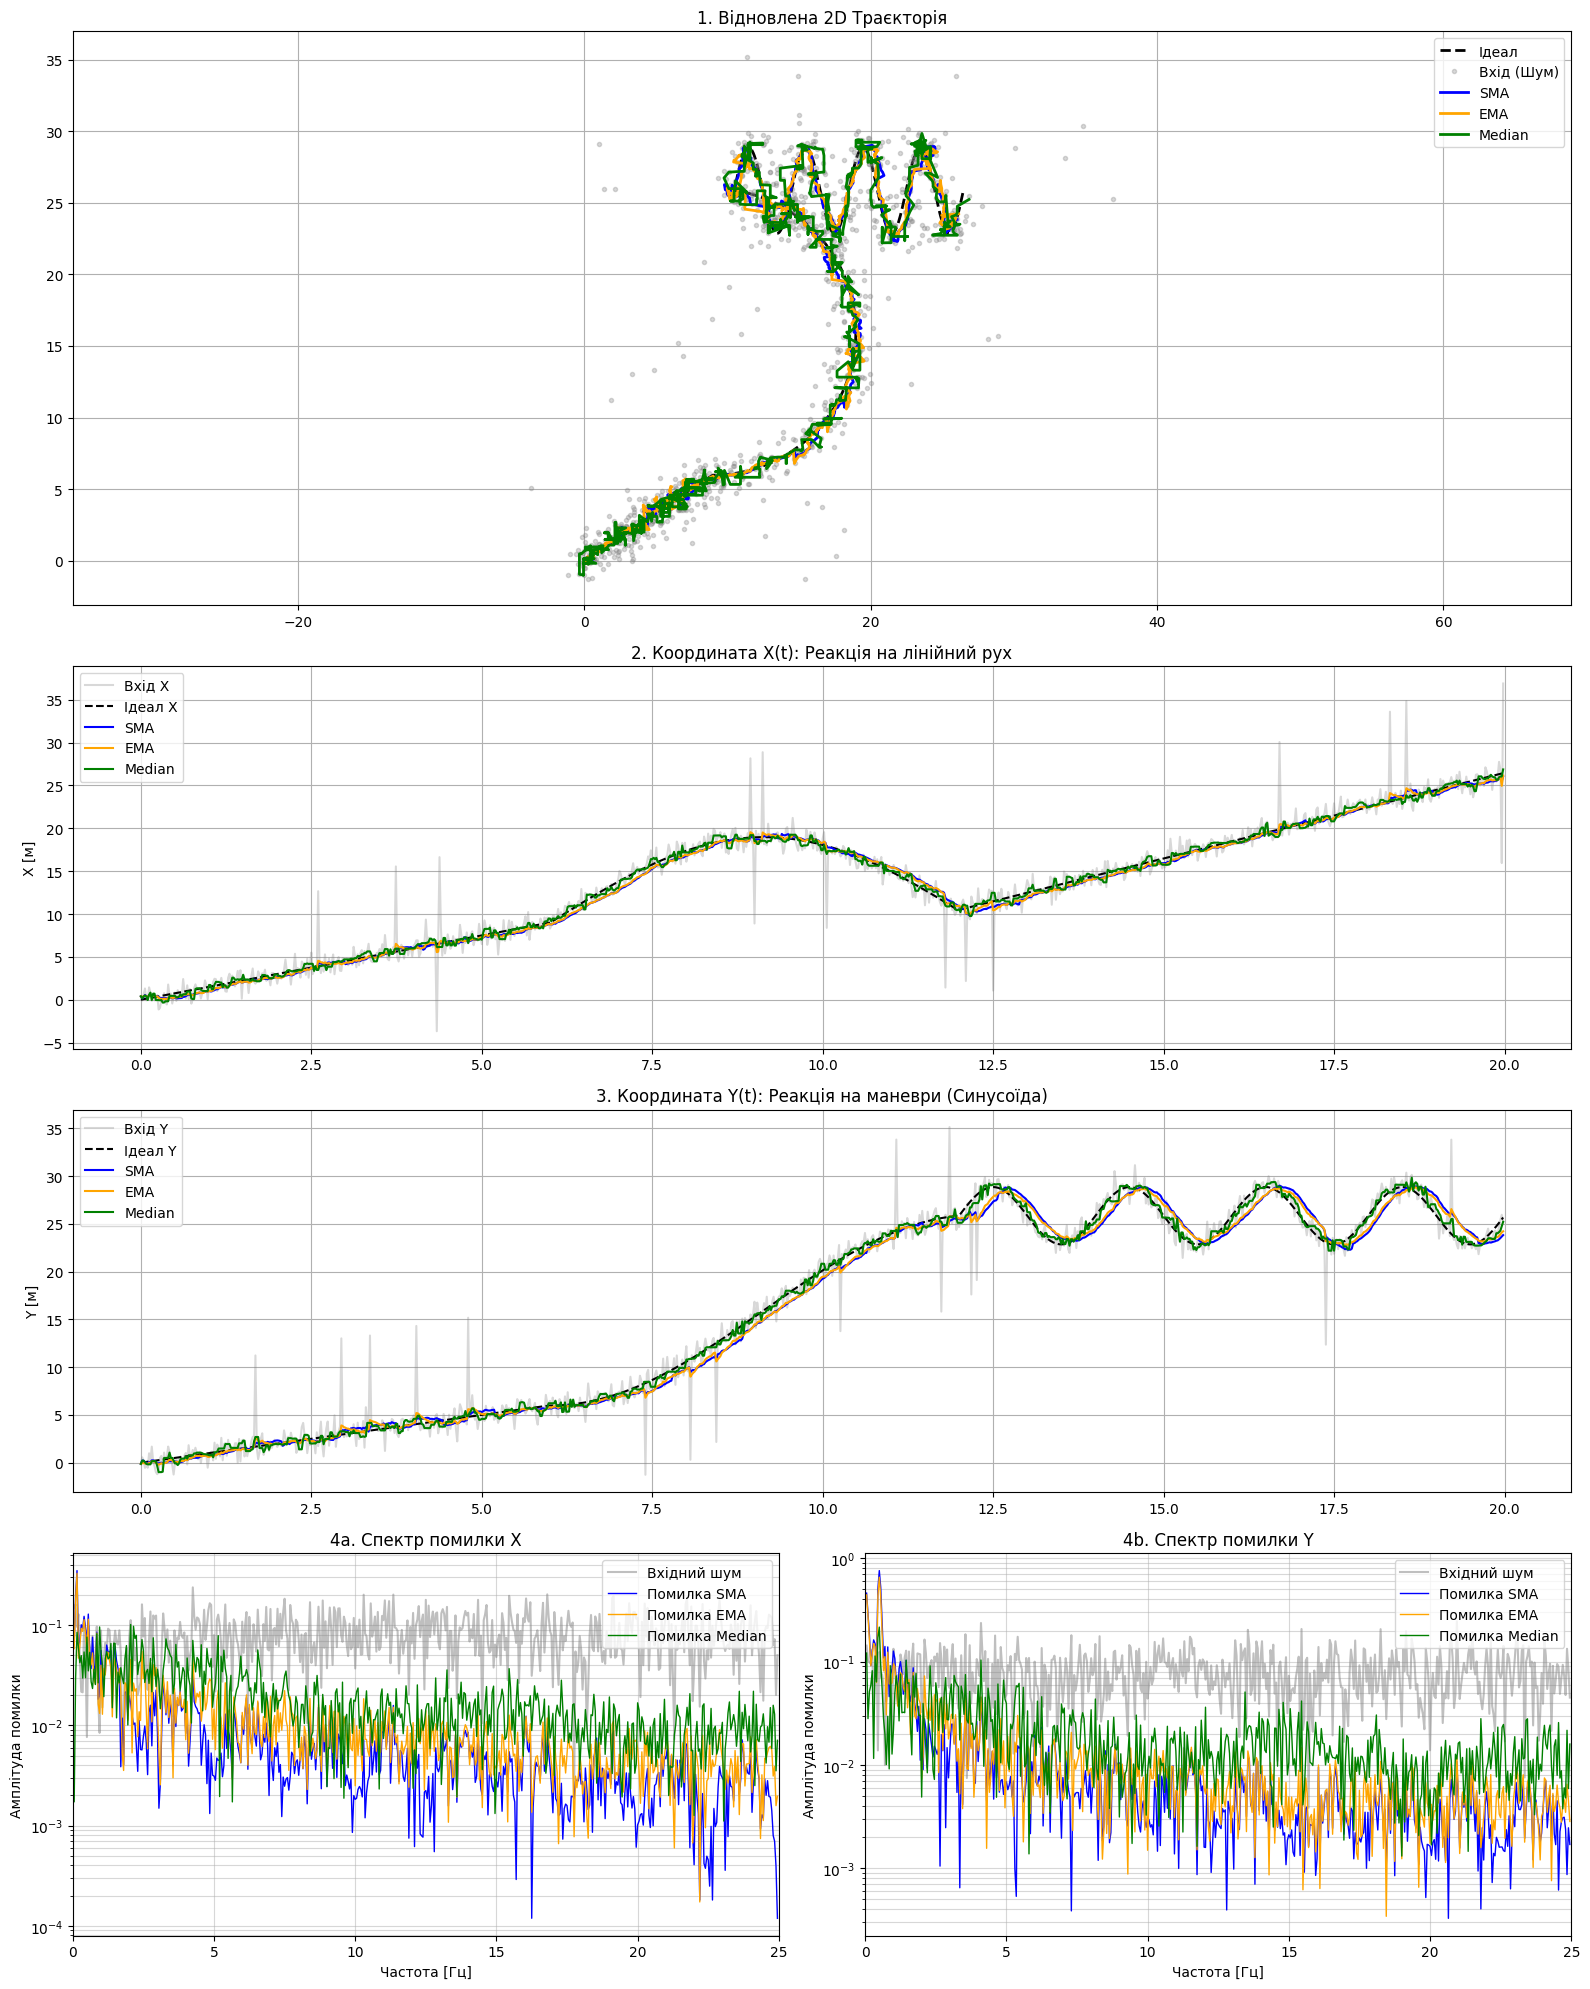

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.fft import fft, fftfreq

# --- 1. ГЕНЕРАТОР ДАНИХ —
FS = 50.0        # Частота дискретизації: 50 Гц
DURATION = 20.0  # Тривалість: 20 секунд
N = int(FS * DURATION)
T = np.linspace(0, DURATION, N, endpoint=False)

# Налаштування складності (можна змінювати в ході роботи)
NOISE_STD = 0.8          # "Тремтіння" сенсора (метри)
OUTLIER_PROB = 0.02      # Ймовірність викиду (2%)
OUTLIER_SCALE = 10.0     # Амплітуда викиду (метри)
np.random.seed(42)

# --- Генерація Ідеальної Траєкторії (Ground Truth) ---
true_x = np.zeros(N); true_y = np.zeros(N)

# Етап 1: Пряма (0-6 с)
mask1 = (T < 6)
true_x[mask1] = 1.5 * T[mask1]
true_y[mask1] = 1.0 * T[mask1]
lx, ly = true_x[mask1][-1], true_y[mask1][-1]

# Етап 2: Поворот (6-12 с)
mask2 = (T >= 6) & (T < 12)
dt2 = T[mask2] - 6
true_x[mask2] = lx + 10 * np.sin(0.5 * dt2)
true_y[mask2] = ly + 10 * (1 - np.cos(0.5 * dt2))
lx, ly = true_x[mask2][-1], true_y[mask2][-1]

# Етап 3: Змійка (12-20 с)
mask3 = (T >= 12)
dt3 = T[mask3] - 12
true_x[mask3] = lx + 2.0 * dt3
true_y[mask3] = ly + 3.0 * np.sin(2 * np.pi * 0.5 * dt3)


# --- Додавання шуму ---

def add_noise(signal):
    gaussian = np.random.normal(0, NOISE_STD, len(signal))
    outliers = np.zeros(len(signal))

    # Маска викидів
    idx = np.random.rand(len(signal)) < OUTLIER_PROB
    outliers[idx] = np.random.choice([-1, 1], size=idx.sum()) * OUTLIER_SCALE

    return signal + gaussian + outliers

meas_x = add_noise(true_x)
meas_y = add_noise(true_y)

# --- 2. ЗАГОТОВКИ ФІЛЬТРІВ (Ваше завдання - реалізувати методи update) ---

class SMAFilter:
    def __init__(self, w):
        self.w = w
        self.q = deque(maxlen=w)
        self.sum = 0.0 # Для оптимізації O(1)


    def update(self, x):
        if len(self.q) == self.w:
            self.sum -= self.q[0]
        self.q.append(x)
        self.sum += x
        return self.sum / len(self.q)

class EMAFilter:
    def __init__(self, alpha):
        self.a = alpha
        self.last = None

    def update(self, x):
        if self.last is None:
            self.last = x
            return x
        self.last = self.a * x + (1 - self.a) * self.last
        return self.last

class MedianFilter:
    def __init__(self, w):
        if w % 2 == 0: w += 1
        self.w = w
        self.q = deque(maxlen=w)

    def update(self, x):
        self.q.append(x)
        return np.median(self.q)

# --- 3. ОБРОБКА ПОТОКУ ---

# Експериментальні параметри (змінюйте їх!)
W_SMA = 20
A_EMA = 0.1
W_MED = 5

filters = {
    'SMA': (SMAFilter(W_SMA), SMAFilter(W_SMA), [], [], 'blue'),
    'EMA': (EMAFilter(A_EMA), EMAFilter(A_EMA), [], [], 'orange'),
    'Median': (MedianFilter(W_MED), MedianFilter(W_MED), [], [], 'green')
}

# Симуляція Real-time потоку
for mx, my in zip(meas_x, meas_y):
    for name, (fx, fy, out_x, out_y, _) in filters.items():
        out_x.append(fx.update(mx))
        out_y.append(fy.update(my))

# --- 4. ВІЗУАЛІЗАЦІЯ ---
fig = plt.figure(figsize=(16, 20))
gs = fig.add_gridspec(4, 2, height_ratios=[1.5, 1, 1, 1])

# 1. 2D КАРТА
ax_map = fig.add_subplot(gs[0, :])
ax_map.plot(true_x, true_y, 'k--', linewidth=2, label='Ідеал')
ax_map.plot(meas_x, meas_y, 'o', color='gray', alpha=0.3, markersize=3, label='Вхід (Шум)')

for name, (_, _, ox, oy, c) in filters.items():
    ax_map.plot(ox, oy, color=c, linewidth=2, label=name)
ax_map.set_title('1. Відновлена 2D Траєкторія')
ax_map.legend(); ax_map.axis('equal'); ax_map.grid(True)

# 2. ЧАСОВИЙ ГРАФІК X
ax_tx = fig.add_subplot(gs[1, :])
ax_tx.plot(T, meas_x, color='gray', alpha=0.3, label='Вхід X')
ax_tx.plot(T, true_x, 'k--', linewidth=1.5, label='Ідеал X')

for name, (_, _, ox, _, c) in filters.items():
    ax_tx.plot(T, ox, color=c, linewidth=1.5, label=name)

ax_tx.set_title(f'2. Координата X(t): Реакція на лінійний рух')
ax_tx.set_ylabel('X [м]'); ax_tx.legend(loc='upper left'); ax_tx.grid(True)

# 3. ЧАСОВИЙ ГРАФІК Y
ax_ty = fig.add_subplot(gs[2, :])
ax_ty.plot(T, meas_y, color='gray', alpha=0.3, label='Вхід Y')
ax_ty.plot(T, true_y, 'k--', linewidth=1.5, label='Ідеал Y')

for name, (_, _, _, oy, c) in filters.items():
    ax_ty.plot(T, oy, color=c, linewidth=1.5, label=name)

ax_ty.set_title('3. Координата Y(t): Реакція на маневри (Синусоїда)')
ax_ty.set_ylabel('Y [м]'); ax_ty.legend(loc='upper left'); ax_ty.grid(True)

# 4. СПЕКТРИ ПОМИЛКИ
def plot_error_spectrum(ax, true_sig, meas_sig, filter_results, title):
    # Спектр вхідного шуму (Meas - True)
    noise = np.array(meas_sig) - true_sig
    yf = fft(noise); xf = fftfreq(len(noise), 1/FS); mask = xf > 0

    ax.plot(xf[mask], 2.0/N * np.abs(yf[mask]), color='gray', alpha=0.5, label='Вхідний шум')


    # Спектр помилки фільтрації (Output - True)
    for name, res, color in filter_results:
        err = np.array(res) - true_sig # Помилка = (Спотворення сигналу) + (Залишок шуму)
        yf_err = fft(err)

        ax.plot(xf[mask], 2.0/N * np.abs(yf_err[mask]), color=color, linewidth=1, label=f'Помилка {name}')

    ax.set_yscale('log'); ax.set_title(title); ax.grid(True, which='both', alpha=0.5)
    ax.set_xlim(0, FS/2); ax.set_xlabel('Частота [Гц]'); ax.set_ylabel('Амплітуда помилки')
    ax.legend(loc='upper right')

# Спектри X та Y
ax_sx = fig.add_subplot(gs[3, 0])
res_x = [(name, out_x, c) for name, (_, _, out_x, _, c) in filters.items()]

plot_error_spectrum(ax_sx, true_x, meas_x, res_x, '4a. Спектр помилки X')

ax_sy = fig.add_subplot(gs[3, 1])
res_y = [(name, out_y, c) for name, (_, _, _, out_y, c) in filters.items()]

plot_error_spectrum(ax_sy, true_y, meas_y, res_y, '4b. Спектр помилки Y')


plt.tight_layout()

plt.show()